# Qwen3-0.6B Architecture

```Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024) --> vocab size 152K, embedding dim 1024
    (layers): ModuleList( --> decoder stack w/ 28 layers, each layer has attention block, mlp, and layer norm
      (0-27): 28 x Qwen3DecoderLayer( --> layer module
        (self_attn): Qwen3Attention( --> attention block
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False) --> W_q, transform input to Q, has 2x features of KV implying GQA
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False) --> W_k, transform input to K
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False) --> W_v, transform input to V
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False) --> merge attention results from all heads back to embedding (hidden) dim
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06) --> part of QK norm
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06) --> part of QK norm
        )
        (mlp): Qwen3MLP( --> feed-forward block
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False) --> runs in parallel with up_proj, output is passed through act_fn then multiplied by up_proj (SwiGLU activation)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False) --> runs in parallel with gate_proj
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False) --> projects expanded dim back to hidden dim
          (act_fn): SiLUActivation() --> activation function
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06) --> stabilize input before it enters attention mechanism
        (post_attention_layernorm): Qwen3RMSNorm((1024,), eps=1e-06) --> stabilize output after attention is applied
      )
    )
    (norm): Qwen3RMSNorm((1024,), eps=1e-06) --> ensure 28 layers' output is scaled correctly
    (rotary_emb): Qwen3RotaryEmbedding() --> applies rotation to encode positional info
  )
  (lm_head): Linear(in_features=1024, out_features=151936, bias=False) --> projects hidden space to log-probs over vocabulary
)
```

# Profiling Notes

- `mlp.down_proj` is the largest matmul (tied with `gate_proj` and `up_proj`)
- `self_attn.q_proj` is the largest attn projection (tied with `self_attn.o_proj`)
- `lm_head` projection to the large vocabulary size can be heavy during prefill when processing long prompts
- `RMSNorm` can cause kernel launch overhead

# Import Libraries

In [ ]:
import random
import torch
import numpy as np
from datasets import load_dataset
from torch.profiler import profile, record_function, ProfilerActivity
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load Model

In [ ]:
model_name = "Qwen/Qwen3-0.6B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype="auto").cuda()

# Dataset Helpers

In [ ]:
def load_mmlu_subset(subject="all", sample_size=50, seed=42):
    """
    load a repeatable random subset of MMLU
    """
    random.seed(seed)

    # load the entire dataset
    dataset = load_dataset("cais/mmlu", subject, split="test")

    # shuffle and select subset
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    subset_indices = indices[:sample_size]

    return dataset.select(subset_indices)

def format_mmlu_prompt(example):
    """
    prompt with a primer at the end
    """
    prompt = f"Question: {example['question']}\n"
    for i, choice in enumerate(["A", "B", "C", "D"]):
        prompt += f"{choice}. {example['choices'][i]}\n"
    # prime the LLM to begin answering with the letter corresponding to its choice
    prompt += "\nAnswer:"
    return prompt

def evaluate(example, model, tokenizer):
    """
    evaluate a local model on the prompt
    """
    with record_function("FORMAT_PROMPT"):
        prompt = format_mmlu_prompt(example)

    with record_function("TOKENIZE"):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with record_function("FORWARD"):
        with torch.no_grad():
            logits = model(**inputs).logits[:, -1, :]

    # define token IDs for A, B, C, D
    choice_tokens = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(token, add_special_tokens=False)[-1] for token in choice_tokens]

    # extract logits for choice tokens
    choice_logits = logits[0, choice_ids] # keep first dimension (batch), select choice_ids from second dim
    prediction_idx = torch.argmax(choice_logits).item()

    return choice_tokens[prediction_idx]


# Profiling Helpers

In [ ]:
def add_profiling_hooks(model):
    """
    recursively add profiling contexts to each named submodule of the model
    """
    for name, module in model.named_modules():
        # only label "leaf" layers
        if len(list(module.children())) == 0:
            original_forward = module.forward
            def patched_forward(*args, name=name, og_fwd=original_forward, **kwargs):
                with record_function(f"LAYER: {name}"):
                    return og_fwd(*args, **kwargs)
            module.forward = patched_forward

# Patch Model Forward Layers

In [ ]:
add_profiling_hooks(model)

# Warm Up Model & Begin Profiling

In [ ]:
inputs = tokenizer("explain what LLMs are", return_tensors="pt").to("cuda")

# warm up the model before profiling
for _ in range(2):
    _ = model.generate(**inputs, max_new_tokens=1)

subset = load_mmlu_subset(sample_size=10)
correct_count = 0
# begin profiling outside of loop to get aggregate results from all examples
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True,
    with_stack=True
) as prof:
    for i, example in enumerate(subset):
        ground_truth = ["A", "B", "C", "D"][example['answer']]

        pred = evaluate(example, model, tokenizer)

        is_correct = (pred == ground_truth)
        if is_correct: correct_count += 1

        print(f"[{i+1}] Pred: {pred} | Actual: {ground_truth} | {'✅' if is_correct else '❌'}")

print(f"\nFinal Accuracy: {correct_count/len(subset):.2%}")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

[1] Pred: C | Actual: B | ❌
[2] Pred: D | Actual: C | ❌
[3] Pred: C | Actual: C | ✅
[4] Pred: B | Actual: B | ✅
[5] Pred: D | Actual: A | ❌
[6] Pred: D | Actual: D | ✅
[7] Pred: D | Actual: D | ✅
[8] Pred: B | Actual: C | ❌
[9] Pred: D | Actual: D | ✅
[10] Pred: D | Actual: B | ❌

Final Accuracy: 50.00%
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --

In [ ]:
prof.export_chrome_trace("trace_1_run_labeled.json")

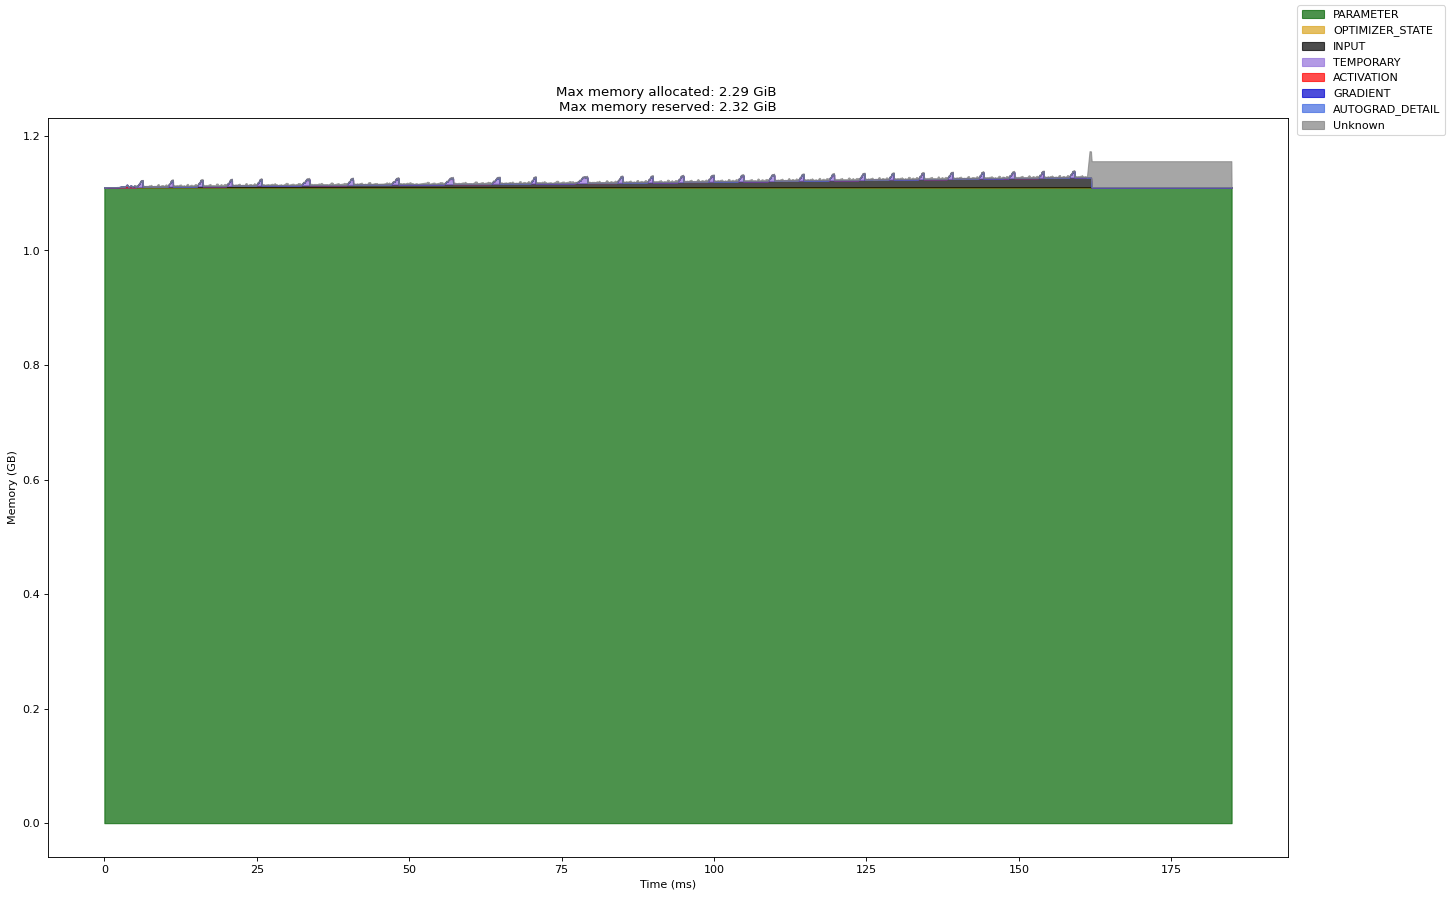

In [ ]:
# Generates a standalone HTML with specialized memory graphs
prof.export_memory_timeline("memory_viz.html", device="cuda:0")

# Archived

In [ ]:
# prompt = "explain what LLMs are"
# inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# # warm up the model before profiling
# for _ in range(2):
#     _ = model.generate(**inputs, max_new_tokens=1)

# # do profiling
# with profile(
#     activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#     record_shapes=True, # track tensor dimensions (helps identify GQA)
#     profile_memory=True, # track allocs and deallocs
#     with_stack=True, # maps python code to kernels
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/qwen3_profile')
# ) as prof:
#     with record_function("model_generation"):
#         output = model.generate(
#             **inputs,
#             max_new_tokens=20,
#             do_sample=False, # False = deterministic, True = probabilistic
#             use_cache=True # enable KV-caching
#         )

# table = prof.key_averages().table(sort_by="cuda_time_total", row_limit=15)
# print(table)

# # prof.export_chrome_trace("qwen3_trace.json")